# Solve DC resistivity PDE using a PINN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras import Sequential

# Set up the problem

We're solving a DC resistivity problem: $\nabla \cdot \left( \sigma \nabla u \right) = f$. To keep things simple, let's solve this for a single point (pole) source of current $I$ at $x=0, y=0, z=0$. The analytical solution to this is $u = \frac{I}{2 \pi \sigma r}$, where $r=x^2+y^2+z^2$. Unfortunately there is a boundary condition at infinity; we'll cheat a bit and use the analytical solution to compute the value of u at a half-spherical boundary that is a finite distance away from the source. 

In [2]:
I = 1000.
sigma = 1.
# radius of hemispherical boundary
R_b = 1000.
# potential at boundary
u_b2_value = I/(2*np.pi*sigma*R_b)
print(u_b2_value)
# radius of hemispherical source volume
R_f = 10.

0.15915494309189535


# Set up the neural networks

Here's our neural network. We'll call it `network`. NOTE: using a piecewise linear activation function won't work, since we need analytic second derivatives.

In [3]:
n_hidden_layers = 9
width = 40
network = tf.keras.Sequential()
network.add(InputLayer(input_shape=(3)))
#network.add(Dense(20))
for _ in range(n_hidden_layers):
    network.add(Dense(width, activation=tf.nn.tanh,
                      kernel_initializer="glorot_normal"
                     ))
network.add(Dense(1, activation=None))

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1

Here's how to call it. It takes an `x` coordinate, a `y` coordinate, and a `z` coordinate as input, and it outputs the potential `u`. Right now, of course, the output is garbage because we haven't trained the network.

In [4]:
x = tf.convert_to_tensor([[-0.5]])
y = tf.convert_to_tensor([[-0.2]])
z = tf.convert_to_tensor([[0.5]])
xyz = tf.concat([x, y, z], 1)

print(network(xyz))

tf.Tensor([[0.12004225]], shape=(1, 1), dtype=float32)


It's a bit of a pain to convert numbers into Tensorflow tensors. Let's write a function that does that.

In [5]:
def to_tf(x):
    return tf.reshape(tf.convert_to_tensor(x, dtype=tf.float32), 
                      (-1, 1))

Let's define a function that can take x, y, and z as individual inputs. That'll make gradients easier later on.

In [6]:
def net_u(x, y, z):
    # rescale x, y, and z to vary between -1 and 1
    # actually, z will vary between 0 and 1
    R_b_tf = to_tf(R_b)
    #half_R_B_tf = to_tf(R_b/2)
    x_scale = x/R_b_tf
    y_scale = y/R_b_tf
    z_scale = z/R_b_tf
    
    u = network(tf.concat([x_scale, y_scale, z_scale], 1))
    return u

In [7]:
net_u(x, y, z)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0001354]], dtype=float32)>

Let's plot the output over the ground surface. We'll write a function so that we can reuse it.

In [8]:
def plot_u_surface(xmin=-100, xmax=100, ymin=-100, ymax=100):
    test_surf_xv = np.linspace(xmin, xmax, 101)
    test_surf_yv = np.linspace(ymin, ymax, 101)
    test_surf_x, test_surf_y = np.meshgrid(test_surf_xv, test_surf_yv)
    test_surf_x = test_surf_x.flatten()
    test_surf_y = test_surf_y.flatten()
    test_surf_z = np.zeros_like(test_surf_x)

    test_surf_x_tf = to_tf(test_surf_x)
    test_surf_y_tf = to_tf(test_surf_y)
    test_surf_z_tf = to_tf(test_surf_z)

    u_pre = net_u(test_surf_x_tf, test_surf_y_tf, test_surf_z_tf+.1)
    u_plot = u_pre.numpy().reshape(101, 101)
    fig, ax = plt.subplots()
    im = ax.imshow(u_plot, extent=(xmin, xmax, ymin, ymax))
    fig.colorbar(im, ax=ax)
    return fig, ax

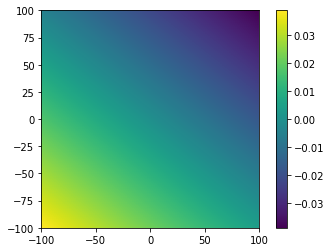

In [9]:
fig, ax = plot_u_surface()

Here's the function to evaluate the left side of the PDE equation using the neural network to compute gradients.

In [10]:
def net_f(x, y, z, sigma=1.):
    sigma = tf.constant(sigma)
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    # persistent=True because otherwise the tape goes away after the first
    # call to g.gradient()
    with tf.GradientTape(persistent=True) as g:
        # Watching the three inputs we’ll need later, x, y, and z
        g.watch(x)
        g.watch(y)
        g.watch(z)
        # a second GradientTape lets us compute second derivatives
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            gg.watch(z)
            # Getting the prediction
            u = net_u(x, y, z)
        # Deriving INSIDE the tape g (since we’ll need second derivatives later, e.g., su_xx)
        u_x = gg.gradient(u, x)
        u_y = gg.gradient(u, y)
        u_z = gg.gradient(u, z)
        su_x = sigma*u_x
        su_y = sigma*u_y
        su_z = sigma*u_z

    # Getting the other derivatives
    su_xx = g.gradient(su_x, x)
    su_yy = g.gradient(su_y, y)
    su_zz = g.gradient(su_z, z)

    # Letting the tapes go
    del gg
    del g

    # Buidling the PINNs
    return -su_xx - su_yy - su_zz

Let's try it out!

In [11]:
net_f(x, y, z)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.5063508e-10]], dtype=float32)>

Let's test it by finite difference!

In [12]:
h = 1e1
xfd = to_tf([x-h, x, x+h])
yfd = to_tf([y-h, y, y+h])
zfd = to_tf([z-h, z, z+h])

xs = to_tf([x]*3)
ys = to_tf([y]*3)
zs = to_tf([z]*3)

dd2 = np.array([1, -2, 1])/h/h

uxx = np.dot(net_u(xfd, ys, zs).numpy().flatten(), dd2)
uyy = np.dot(net_u(xs, yfd, zs).numpy().flatten(), dd2)
uzz = np.dot(net_u(xs, ys, zfd).numpy().flatten(), dd2)

- uxx - uyy - uzz

3.8737198337736377e-10

We could use a plotting function for f as well, just to examine it. Here's one for f at the surface.

In [13]:
def plot_f_surface(xmin=-100, xmax=100, ymin=-100, ymax=100):
    test_surf_xv = np.linspace(xmin, xmax, 101)
    test_surf_yv = np.linspace(ymin, ymax, 101)
    test_surf_x, test_surf_y = np.meshgrid(test_surf_xv, test_surf_yv)
    test_surf_x = test_surf_x.flatten()
    test_surf_y = test_surf_y.flatten()
    test_surf_z = np.zeros_like(test_surf_x)

    test_surf_x_tf = to_tf(test_surf_x)
    test_surf_y_tf = to_tf(test_surf_y)
    test_surf_z_tf = to_tf(test_surf_z)

    f_pre = net_f(test_surf_x_tf, test_surf_y_tf, test_surf_z_tf+.1)
    f_plot = f_pre.numpy().reshape(101, 101)
    fig, ax = plt.subplots()
    im = ax.imshow(f_plot, extent=(xmin, xmax, ymin, ymax))
    fig.colorbar(im, ax=ax)
    return fig, ax

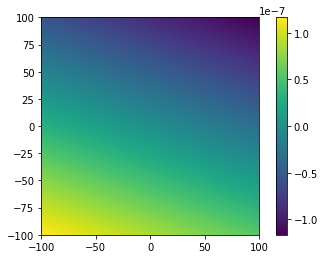

In [14]:
fig, ax = plot_f_surface()

We want to train this network to produce the source term (mostly 0, except at the point source, where this should be a delta function times I). That's how we form half of the loss function. The other half of the loss function enforces boundary conditions. There are two boundary conditions: Dirichlet in the subsurface, far from the source, and 0 Neumann at the surface. Since the Dirichlet boundary condition applies to `u`, we can use `net_u()` to enforce it. To enforce the zero Neumann boundary condition, though, we'll need a way to get the normal derivative at the surface. Let's write a function to return u_z at the surface.

In [15]:
def net_u0_z(x, y):
    #z0 = tf.constant([[0.]])
    z0 = tf.zeros_like(x)
    with tf.GradientTape() as g:
        g.watch(z0)
        u0 = net_u(x, y, z0)
    u0_z = g.gradient(u0, z0)
    return u0_z

In [16]:
net_u0_z(x, y)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00018502]], dtype=float32)>

Let's test it by finite difference!

In [17]:
h = 1e-2
zfd = to_tf([-h, h])

xs = to_tf([x]*2)
ys = to_tf([y]*2)

dz = np.array([-1, 1])/2/h

uz = np.dot(net_u(xs, ys, zfd).numpy().flatten(), dz)

uz

0.00018502432794775814

Shall we write a plotting function for this, too? Oh, why not.

In [18]:
def plot_uz_surface(xmin=-100, xmax=100, ymin=-100, ymax=100):
    test_surf_xv = np.linspace(xmin, xmax, 101)
    test_surf_yv = np.linspace(ymin, ymax, 101)
    test_surf_x, test_surf_y = np.meshgrid(test_surf_xv, test_surf_yv)
    test_surf_x = test_surf_x.flatten()
    test_surf_y = test_surf_y.flatten()

    test_surf_x_tf = to_tf(test_surf_x)
    test_surf_y_tf = to_tf(test_surf_y)

    uz_pre = net_u0_z(test_surf_x_tf, test_surf_y_tf)
    uz_plot = uz_pre.numpy().reshape(101, 101)
    fig, ax = plt.subplots()
    im = ax.imshow(uz_plot, extent=(xmin, xmax, ymin, ymax))
    fig.colorbar(im, ax=ax)
    return fig, ax

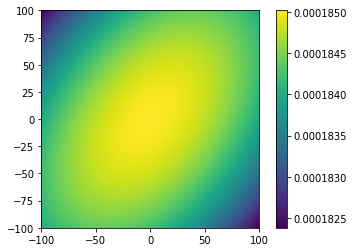

In [19]:
fig, ax = plot_uz_surface()

# Set up the sampling locations

Now we need to choose locations at which to enforce the two parts of the loss function: the PDE itself, and the boundary conditions. To begin, let's sample at the surface. I'm calling this boundary 1, or `b1` for short. This is where we enforce the zero Neumann boundary condition. These points lie at the ground-air interface inside a circle of radius `R_b`.

In [20]:
def sample_circle(n):
    '''
    Draw n samples from a uniform distribution inside a circle
    '''
    r = np.sqrt(np.random.rand(n))
    theta = 2*np.pi*np.random.rand(n)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return np.c_[x,y]
    

n_b1 = 5000
b1 = R_b*sample_circle(n_b1)
xb1 = b1[:, 0]
yb1 = b1[:, 1]
# check that all points lie inside within R_b of the source
print(np.linalg.norm(b1, axis=1).max())

999.7457582777405


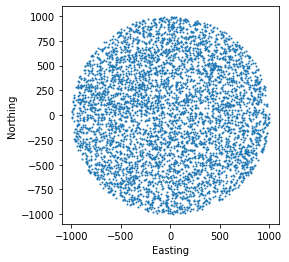

In [21]:
plt.scatter(xb1, yb1, s=1)
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.axis('square')
plt.show()

Next, we sample on the boundary in the subsurface, at distance `R_b` from the source. This is where we enforce the Dirichlet boundary condition. These points lie on the surface of a hemisphere of radius `R_b`. I'll call this `b2`.

In [22]:
def sample_sphere_surface(n):
    '''
    Draw n samples from a uniform distribution across the surface of a sphere in cartesian coordinates
    '''
    xyz = np.random.normal(0,1,(n,3))
    r = np.linalg.norm(xyz, axis=1)
    return xyz/r[:, None]   

n_b2 = n_b1*2

# sample on a half-sphere surface for the far boundary
b2 = R_b*sample_sphere_surface(n_b2)
xb2 = b2[:, 0]
yb2 = b2[:, 1]
# half sphere: only positive z
zb2 = np.abs(b2[:, 2])
u_b2_exact = np.array([u_b2_value]*b2.shape[0])
# check that all points lie on the boundary (there is a bit of rounding error)
print(np.unique(np.linalg.norm(b2, axis=1)))

[1000. 1000. 1000. 1000. 1000. 1000. 1000.]


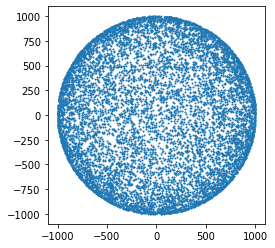

In [23]:
plt.scatter(xb2, yb2, s=1)
plt.axis('square')
plt.show()

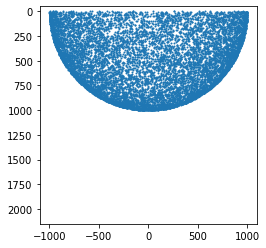

In [24]:
plt.scatter(xb2, zb2, s=1)
plt.axis('square')
plt.gca().invert_yaxis()
plt.show()

Okay, now let's sample within the volume. This is where we enforce the PDE. Here I'll go off the rails a bit, and sample more densely near the point source.

In [25]:
def sample_sphere_uniform(n):
    '''
    Draw n samples uniformly from within the volume encompassed by a sphere
    Unused: I decided to try sampling more near the source.
    '''
    phi = 2*np.pi*np.random.rand(n)
    costheta = 2*np.random.rand(n) - 1
    r = np.cbrt(np.random.rand(n))
    theta = np.arccos(costheta)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * costheta
    return np.c_[x, y, z]

In [26]:
def sample_sphere_uniform_r(n):
    '''
    Draw n samples from within the volume encompassed by a sphere
    such that the radii follow a uniform distribution
    '''
    phi = 2*np.pi*np.random.rand(n)
    costheta = 2*np.random.rand(n) - 1
    r = np.random.rand(n)
    theta = np.arccos(costheta)
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * costheta
    return np.c_[x, y, z]

In [27]:
n_f = 10000

bf = R_b*sample_sphere_uniform_r(n_f)
xf = bf[:, 0]
yf = bf[:, 1]
# half sphere: only positive z
zf = np.abs(bf[:, 2])
# check that no point lies outside the boundary
(np.linalg.norm(bf, axis=1)).max()

999.9818468802032

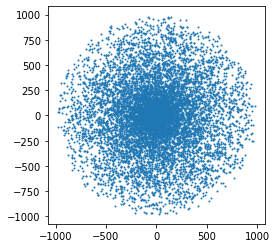

In [28]:
plt.scatter(xf, yf, s=1)
plt.axis('square')
plt.show()

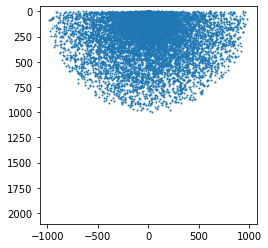

In [29]:
plt.scatter(xf, zf, s=1)
plt.axis('square')
plt.gca().invert_yaxis()
plt.show()

We'll also need to deal with the singularity at the point source. Let's approximate the point source by a small hemisphere of radius `R_f` and volume $v$, where the source term inside the hemisphere is $f=\frac{I}{v}$. First, let's make sure we have some samples inside `R_f`.

In [30]:
rf = np.linalg.norm(bf, axis=1)
rf_in_source = rf < R_f
print(rf_in_source.sum())

94


Now let's create a source term which is zero everywhere except inside the source.

In [31]:
f_true = np.zeros_like(rf)
v_f = 2/3*np.pi*R_f**3
f_true_value = I/v_f
f_true[rf_in_source] = f_true_value

Let's write functions to resample across each boundary surface and throughout the domain so that we can randomize locations after each training epoch.

In [32]:
def sample_b1(n):
    b1 = R_b*sample_circle(n)
    xb1 = to_tf(b1[:, 0])
    yb1 = to_tf(b1[:, 1])
    return (xb1, yb1)

def sample_b2(n):
    # sample on a half-sphere surface for the far boundary
    b2 = R_b*sample_sphere_surface(n)
    xb2 = to_tf(b2[:, 0])
    yb2 = to_tf(b2[:, 1])
    # half sphere: only positive z
    zb2 = to_tf(np.abs(b2[:, 2]))
    u_b2_exact = to_tf([u_b2_value]*b2.shape[0])
    return (xb2, yb2, zb2, u_b2_exact)

def sample_f(n):
    bf = R_b*sample_sphere_uniform_r(n)
    xf = to_tf(bf[:, 0])
    yf = to_tf(bf[:, 1])
    # half sphere: only positive z
    zf = to_tf(np.abs(bf[:, 2]))
    rf = np.linalg.norm(bf, axis=1)
    rf_in_source = rf < R_f
    f_true = np.zeros_like(rf)
    f_true[rf_in_source] = f_true_value
    return(xf, yf, zf, to_tf(f_true))

Great! We're ready to compute the loss. 
The loss consists of three terms: 
1. The boundary at the surface, `b1_loss`
2. The boundary in the subsurface, `b2_loss`
3. The PDE within the domain, `f_loss`

In [33]:
def compute_loss():
    xb1, yb1 = sample_b1(1000)
    u0_z_pred = net_u0_z(xb1, yb1)
    b1_loss = tf.reduce_sum(tf.square(u0_z_pred))
    
    xb2, yb2, zb2, u_b2_exact = sample_b2(2000)
    u_b2_pred = net_u(xb2, yb2, zb2)
    b2_loss = tf.reduce_sum(tf.square(u_b2_exact - u_b2_pred))
    
    xf, yf, zf, f_true = sample_f(10000)
    sigma_tf = tf.constant(sigma)
    f_pred = net_f(xf, yf, zf, sigma=sigma_tf)
    f_loss = tf.reduce_sum(tf.square(f_true - f_pred))
    return b1_loss + b2_loss + 1e6*f_loss, (b1_loss, b2_loss, f_loss)

# Train

We're ready to train! Let's minimize that loss.

In [34]:
optimizer = tf.keras.optimizers.Adam()

In [35]:
training_losses = []
for epoch in range(1, 1000 + 1):
    with tf.GradientTape() as tape:
        loss, loss_terms = compute_loss()
        training_losses.append([lt.numpy() for lt in loss_terms])
    gradients = tape.gradient(loss, network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, network.trainable_variables))
    if epoch % 10 == 0:
        print('Epoch {}: {:.4}'.format(epoch, loss))

Epoch 10: 2.394e+07
Epoch 20: 2.53e+07
Epoch 30: 2.322e+07
Epoch 40: 2.406e+07
Epoch 50: 1.708e+07
Epoch 60: 1.856e+07
Epoch 70: 1.751e+07
Epoch 80: 1.596e+07
Epoch 90: 1.556e+07
Epoch 100: 1.493e+07
Epoch 110: 1.346e+07
Epoch 120: 9.675e+06
Epoch 130: 6.949e+06
Epoch 140: 7.765e+06
Epoch 150: 7.001e+06
Epoch 160: 6.575e+06
Epoch 170: 4.703e+06
Epoch 180: 4.711e+06
Epoch 190: 4.465e+06
Epoch 200: 5.271e+06
Epoch 210: 3.908e+06
Epoch 220: 3.861e+06
Epoch 230: 5.025e+06
Epoch 240: 3.831e+06
Epoch 250: 3.95e+06
Epoch 260: 4.845e+06
Epoch 270: 3.192e+06
Epoch 280: 4.25e+06
Epoch 290: 4.665e+06
Epoch 300: 4.364e+06
Epoch 310: 3.327e+06
Epoch 320: 3.832e+06
Epoch 330: 2.815e+06
Epoch 340: 3.48e+06
Epoch 350: 3.262e+06
Epoch 360: 3.58e+06
Epoch 370: 4.377e+06
Epoch 380: 2.007e+06
Epoch 390: 1.745e+06
Epoch 400: 1.807e+06
Epoch 410: 1.709e+06
Epoch 420: 2.021e+06
Epoch 430: 1.972e+06
Epoch 440: 1.118e+06
Epoch 450: 1.66e+06
Epoch 460: 1.191e+06
Epoch 470: 1.118e+06
Epoch 480: 1.344e+06
Epoch 4

# Evaluate results

How did the training go?

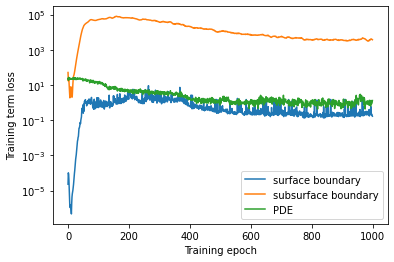

In [36]:
plt.semilogy(training_losses)
plt.legend(['surface boundary', 'subsurface boundary', 'PDE'])
plt.xlabel('Training epoch')
plt.ylabel('Training term loss')
plt.show()

Let's sample the potential and the predicted source on a 2D grid. 

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

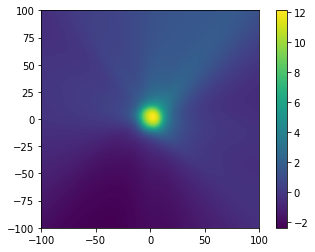

In [37]:
plot_u_surface()

Okay, not bad! What's the expected potential look like?

In [38]:
test_surf_xv = np.linspace(-100, 100, 101)
test_surf_yv = np.linspace(-100, 100, 101)
test_surf_x, test_surf_y = np.meshgrid(test_surf_xv, test_surf_yv)
test_surf_x = test_surf_x.flatten()
test_surf_y = test_surf_y.flatten()
test_surf_z = np.zeros_like(test_surf_x)

test_surf_x_tf = to_tf(test_surf_x)
test_surf_y_tf = to_tf(test_surf_y)
test_surf_z_tf = to_tf(test_surf_z)

<ipython-input-39-8a5a49c7ef08>:2: RuntimeWarning: divide by zero encountered in true_divide
  u_true = I/(2*np.pi*sigma*test_surf_r)


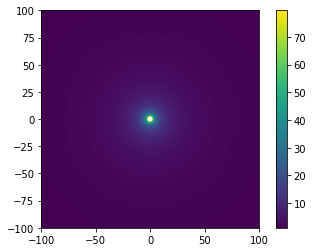

In [39]:
test_surf_r = np.sqrt(test_surf_x**2 + test_surf_y**2 + test_surf_z**2)
u_true = I/(2*np.pi*sigma*test_surf_r)

plt.imshow(u_true.reshape(101,101), extent=(-100, 100, -100, 100))
plt.colorbar()
plt.show()

Well, the infinitesimal source creates large potentials near the source that drown out the rest. Let's clip the colorbar.

<ipython-input-40-53f8aead13af>:2: RuntimeWarning: divide by zero encountered in true_divide
  u_true = I/(2*np.pi*sigma*test_surf_r)


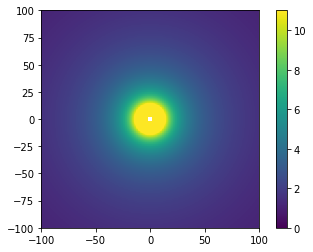

In [40]:
test_surf_r = np.sqrt(test_surf_x**2 + test_surf_y**2 + test_surf_z**2)
u_true = I/(2*np.pi*sigma*test_surf_r)

plt.imshow(u_true.reshape(101,101), extent=(-100, 100, -100, 100),
           vmin=0, vmax=11
          )
plt.colorbar()
plt.show()

Well, it's kinda the same! Let's quantify the error.

In [52]:
errors = []
for _ in range(500):
    xf, yf, zf, ft = sample_f(10000)
    u_pred = net_u(xf, yf, zf)
    rf = np.sqrt(xf**2 + yf**2 + zf**2)
    u_true = I/(2*np.pi*sigma*rf)
    errors.append(np.sum((u_true-u_pred)**2))

(array([ 2.,  3.,  6., 14., 19., 20., 23., 27., 23., 32., 25., 25., 22.,
        33., 25., 20., 18., 15., 15., 23., 14.,  9., 14.,  8.,  8.,  7.,
        11.,  8.,  4.,  3.,  1.,  1.,  3.,  0.,  2.,  5.,  1.,  1.,  0.,
         0.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  2.]),
 array([ 5.446046 ,  5.5633106,  5.6805754,  5.79784  ,  5.9151044,
         6.032369 ,  6.149634 ,  6.2668986,  6.3841634,  6.501428 ,
         6.6186924,  6.735957 ,  6.853222 ,  6.9704866,  7.0877514,
         7.205016 ,  7.3222804,  7.439545 ,  7.55681  ,  7.6740746,
         7.7913394,  7.908604 ,  8.025868 ,  8.143133 ,  8.260398 ,
         8.377663 ,  8.494927 ,  8.612192 ,  8.729457 ,  8.846722 ,
         8.963986 ,  9.081251 ,  9.198515 ,  9.31578  ,  9.433044 ,
         9.550309 ,  9.667574 ,  9.784839 ,  9.902103 , 10.019368 ,
        10.136633 , 10.253898 , 10.371162 , 10.488427 , 10.605691 ,
        10.722956 , 10.84022  , 10.957485 , 11.07475  , 11.192015 ,
        11.309279 ], dtype=float32),

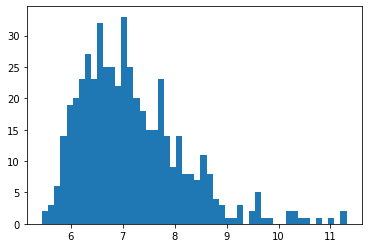

In [53]:
plt.hist(np.log10(errors), bins=50)

In [43]:
10**6.7

5011872.336272725

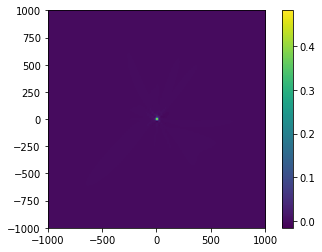

In [44]:
fig, ax = plot_f_surface(-1000, 1000, -1000, 1000)

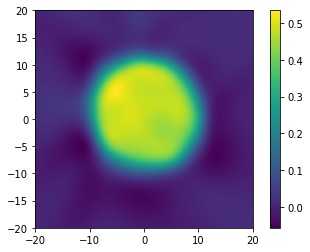

In [45]:
fix, ax = plot_f_surface(-20, 20, -20, 20)

Let's look at some cross-sections, too.

In [46]:
test_xv = np.linspace(-20, 20, 51)
test_yv = np.zeros(51)
test_zv = np.linspace(0, 40, 51)
test_x, test_z = np.meshgrid(test_xv, test_zv)
test_x = test_x.flatten()
test_z = test_z.flatten()
test_y = np.zeros_like(test_x) + 1

In [47]:
test_x_tf = to_tf(test_x)
test_y_tf = to_tf(test_y)
test_z_tf = to_tf(test_z)

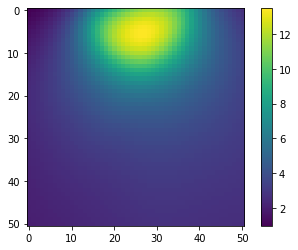

In [48]:
u_pre = net_u(test_x_tf, test_y_tf, test_z_tf)
u_plot = u_pre.numpy().reshape(51, 51)
plt.imshow(u_plot)
plt.colorbar()

That's an x-z cross section. Since x and y are symmetric, we can flip x and y in the call to net_u to obtain a y-z cross section.

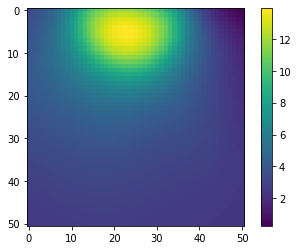

In [49]:
u_pre = net_u(test_y_tf, test_x_tf, test_z_tf)
u_plot = u_pre.numpy().reshape(51, 51)
plt.imshow(u_plot)
plt.colorbar()

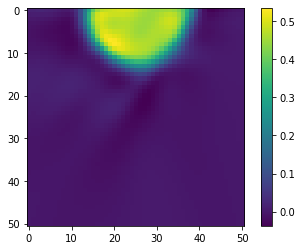

In [50]:
f_pre = net_f(test_x_tf, test_y_tf, test_z_tf)
f_plot = f_pre.numpy().reshape(51, 51)

plt.imshow(f_plot)
plt.colorbar()

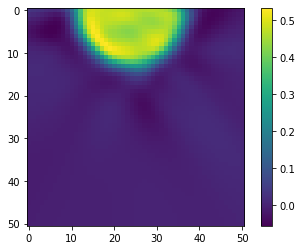

In [51]:
f_pre = net_f(test_y_tf, test_x_tf, test_z_tf)
f_plot = f_pre.numpy().reshape(51, 51)

plt.imshow(f_plot)
plt.colorbar()

Whew! That took a long time to train, but it is working. More modifications could help: batch norm, better weight initialization, different learning rates or optimization, different ratios of samples from boundaries vs from the volume.

__TODO__
- [x] Rescale neural net inputs to -1 -> 1
- [x] Randomize points after each epoch
- [x] Plot true solution
- [x] Plot error